In [17]:
!pip install wandb torch==1.8.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html perceiver-pytorch opencv-python torchvision --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\Ryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [18]:

import wandb
import torch
import time
import cv2
import numpy as np
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from perceiver_pytorch import Perceiver
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
# ?Perceiver

In [30]:
# 1. Start a W&B run
wandb.init(project='fnet-preceiver', entity='rosenblatt')

loss,0.00538
_runtime,2037
_timestamp,1624071115
_step,1249


loss,█▆▅▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [31]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 1e-3
config.batch_size = 128
config.size = 64
config.objects = 1
config.epochs = 10

In [32]:
model = Perceiver(
    input_channels = 3,          # number of channels for each token of the input
    input_axis = 2,              # number of axis for input data (2 for images, 3 for video)
    num_freq_bands = 4,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 5.,              # maximum frequency, hyperparameter depending on how fine the data is
    depth = 2,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    # cross_dim = 32,             # cross attention dimension
    latent_dim = 32,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 4,            # number of heads for latent self attention, 8
    cross_dim_head = 32,
    latent_dim_head = 32,
    num_classes = 4*config.objects,          # output number of classes
    attn_dropout = 0.5,
    ff_dropout = 0.5,
    weight_tie_layers = True    # whether to weight tie layers (optional, as indicated in the diagram)
)

In [33]:
# training the model on very easy object detection problem
class CustomDataset(Dataset):
    def __init__(self):   
      pass
      
    def __len__(self):
        return 320000

    def __getitem__(self, idx):
        image = np.zeros((config.size,config.size,3), np.uint8)
        labels = []

        for i in range(config.objects):
          if (np.random.rand() > 0.02):
            point_x = int(np.random.rand() * size)
            point_y = int(np.random.rand() * size)
            size_x = int(np.random.rand() * size)
            size_y = int(np.random.rand() * size)       
            r, g, b = int(np.random.rand()*255), int(np.random.rand()*255), int(np.random.rand() * 255)  
            try:
              cv2.rectangle(image, (int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)), (r, g, b), -1)            
              labels.append((point_x/size, point_y/size, size_x/size, size_y/size))
            except Exception as e:
              print(e)
              labels.append((0,0,0,0))
          else:            
            labels.append((0,0,0,0))            
                  
        labels = torch.as_tensor(labels, dtype=torch.float32)
        image = torch.as_tensor(image, dtype=torch.float32)

        return (image, labels)

In [34]:
criterion = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, amsgrad=True)

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)

wandb.watch(model)
model.cuda()
model.train()

Perceiver(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_q): Linear(in_features=32, out_features=32, bias=False)
          (to_kv): Linear(in_features=21, out_features=64, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): Dropout(p=0.5, inplace=False)
          )
        )
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm_context): LayerNorm((21,), eps=1e-05, elementwise_affine=True)
      )
      (1): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.5, inplace=False)
            (3): Linear(in_features=128, out_features=32, bias=True)
          )
        )
        (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
      (2): ModuleList(
        (0): ModuleList(
  

In [35]:
for epoch in range(config.epochs):  # loop over the dataset multiple times

  running_loss = 0.0

  for i, (img, labels) in enumerate(dataloader):
        
    img = torch.as_tensor(img, dtype=torch.float32).cuda()

    labels = torch.as_tensor(labels, dtype=torch.float32).cuda()    
    labels = labels.flatten()
    labels = torch.reshape(labels, (batch_size, 4*config.objects))
     
    optimizer.zero_grad()
    out = model(img)
        
   
    loss = criterion(out, labels)             
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 20 == 19:    # print every 2000 mini-batches
        wandb.log({'loss': running_loss / 20})
        print('[%d, %6d] loss: %.6f' %
              (epoch + 1, i + 1, running_loss / 20))
      
        running_loss = 0.0

05
[5,    300] loss: 0.006552
[5,    320] loss: 0.006522
[5,    340] loss: 0.006986
[5,    360] loss: 0.007159
[5,    380] loss: 0.007302
[5,    400] loss: 0.007393
[5,    420] loss: 0.006705
[5,    440] loss: 0.006233
[5,    460] loss: 0.006538
[5,    480] loss: 0.006422
[5,    500] loss: 0.006837
[5,    520] loss: 0.006619
[5,    540] loss: 0.007128
[5,    560] loss: 0.007018
[5,    580] loss: 0.006646
[5,    600] loss: 0.006866
[5,    620] loss: 0.006590
[5,    640] loss: 0.006393
[5,    660] loss: 0.006458
[5,    680] loss: 0.006340
[5,    700] loss: 0.006576
[5,    720] loss: 0.006785
[5,    740] loss: 0.006563
[5,    760] loss: 0.006867
[5,    780] loss: 0.006315
[5,    800] loss: 0.006331
[5,    820] loss: 0.006823
[5,    840] loss: 0.006597
[5,    860] loss: 0.006772
[5,    880] loss: 0.006601
[5,    900] loss: 0.006149
[5,    920] loss: 0.006064
[5,    940] loss: 0.006292
[5,    960] loss: 0.006178
[5,    980] loss: 0.006522
[5,   1000] loss: 0.006715
[5,   1020] loss: 0.00649

input image:


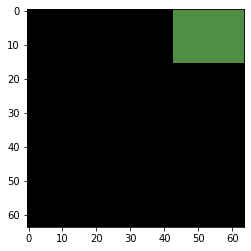

input box location (x, y), (w, h):
(43, -3) (82, 15)
--------------------------------------------------
predicted output:


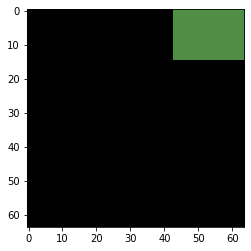

predicted box location (x, y), (w, h):
(43, -8) (70, 14)
--------------------------------------------------


In [41]:
# testing the trained model

model = model.eval()

np.random.seed(np.random.randint(0, 99999))

image = np.zeros((size,size, 3), np.uint8)
labels = []
model = model.cuda()

point_x = int(np.random.rand() * size)
point_y = int(np.random.rand() * size)
size_x = int(np.random.rand() * size)
size_y = int(np.random.rand() * size)       
r, g, b = int(np.random.rand()*255), int(np.random.rand()*255), int(np.random.rand() * 255)  

cv2.rectangle(image, (int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)), (r, g, b), -1)            

print("input image:")
plt.imshow(image)
plt.show()
print("input box location (x, y), (w, h):")
print((int(point_x - size_x/2), int(point_y - size_y/2)), (int(point_x + size_x/2), int(point_y + size_y/2)))

image_tensor = torch.as_tensor(image, dtype=torch.float32)

image_tensor = torch.unsqueeze(image_tensor, 0).cuda()    

image2 = np.ones((size,size, 3), np.uint8)

t1 = time.time()
for i in range(1):
  out = model(image_tensor)
  out = out[0].detach().cpu().numpy()
  
out_point_x = int(out[0] * size)
out_point_y = int(out[1] * size)
out_size_x = int(out[2] * size)
out_size_y = int(out[3] * size)

cv2.rectangle(image2, (int(out_point_x - out_size_x/2), int(out_point_y - out_size_y/2)), (int(out_point_x + out_size_x/2), int(out_point_y + out_size_y/2)), (r, g, b), -1)            

print("-"*50)
print("predicted output:")
plt.imshow(image2)
plt.show()
print("predicted box location (x, y), (w, h):")
print((int(out_point_x - out_size_x/2), int(out_point_y - out_size_y/2)), (int(out_point_x + out_size_x/2), int(out_point_y + out_size_y/2)))
print("-"*50)